CS-E5885 Modeling biological networks (spring 2023)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import expm
from scipy.optimize import least_squares
import networkx as nx

In [2]:
data = pd.read_csv('data.csv', header = 0)

In [3]:
data.head()

,Time/gene,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


In [4]:
# Global variables
t_data = data['Time/gene'].to_numpy()
Y_data = data.drop(columns = ['Time/gene']).to_numpy()
x_init = np.array([[0.076,0.0419,0.0207,0.0225,0.1033]]).T 

## Data visualization

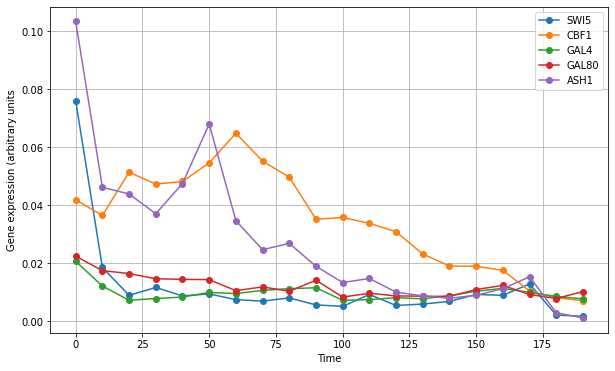

In [5]:
#observe data

plt.figure(figsize=(10,6))
plt.plot(t_data, Y_data, marker = "o")
plt.legend(data.columns[1:])
plt.xlabel('Time')
plt.ylabel('Gene expression (arbitrary units')
plt.grid()
plt.show()

## Visualization of the structure

In [6]:
def visualize_graph(g,t):
    '''
    visualize the structure of an undirected graph m
    
    parameter: 
    G: triangular graph superior matrix 5x5
    
    return: 
    none
    
    '''
    label = data.columns[1:]
    G = nx.Graph() #create a directed graph
    
    G.add_nodes_from(label)
    
    for i in range(g.shape[0]) :
        for j in range(g.shape[1]):
            if i !=j : 
                if g[i][j] ==1 : G.add_edge(label[i], label[j], weight=1)
                
    pos = nx.spring_layout(G)          
    nx.draw_networkx_labels(G,pos)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),node_color = "pink", node_size = 400)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.title(f"Aracne algorithm output graph with treshold = {t}")
    plt.show()

In [7]:
def visualize_model(m):
    '''
    visualize the structure of the model m
    
    parameter: 
    m: model matrix 5x5
    
    return: 
    non
    
    '''
    label = data.columns[1:]
    G = nx.DiGraph() #create a directed graph
    
    G.add_nodes_from(label)
    
    for i in range(m.shape[0]) :
        for j in range(m.shape[1]):
            if m[i][j] ==1 : G.add_edge(label[j], label[i], weight=1 )
                
    pos = nx.spring_layout(G)          
    nx.draw_networkx_labels(G,pos)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),node_color = "pink", node_size = 400)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.title("starting model strucutre")
    plt.show()


## Choice of the starting model

### Kernel density and aracne algorithm for the undirected graph

#### kernel density estimation

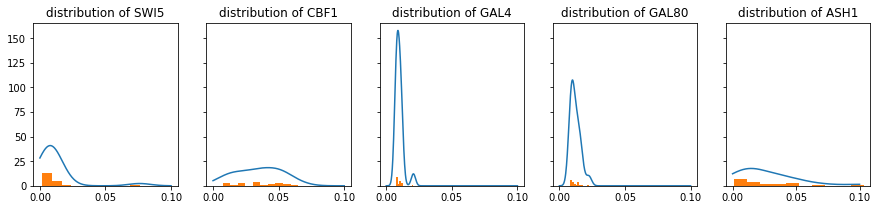

In [8]:
from scipy.stats import norm, gaussian_kde

#for the density of each data
#preparing the plot
t = np.linspace(0, 0.1, 500)
fig, axs = plt.subplots(1, 5,figsize=(15, 3), sharey=True)

#init list of kernel density for each variable
densities = []

#the bandwidth 
bw = []

for i in range(Y_data.shape[1]) : #for each genes
    
    #estimate the distribution
    scipy_kernel = gaussian_kde(Y_data[:,i])
    densities.append(scipy_kernel)
    y= scipy_kernel.evaluate(t)
    
    #plot the histogram of the y values and the distributions
    axs[i].plot(t,y)
    axs[i].hist(Y_data[:,i])

    #title and legend
    axs[i].set_title(f'distribution of {data.columns[1+i]}')
    
    #estimate the bandwidth
    bw.append(scipy_kernel.factor * np.std(Y_data[:,i]))

In [9]:
#for the joint density : we apply the algorithm by considering the variable (X,Y) 
#with the features X and Y for each paires of data

index_name =[]
index = []
data_joint = []

for i in range(0,5) :
    for j in range(i+1,5):
        index_name.append(((data.columns[1:])[i],(data.columns[1:])[j]))
        index.append((i+1,j+1))
        data_joint.append([Y_data[i,:], Y_data[j,:]])

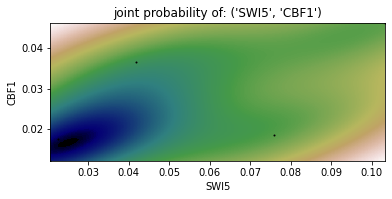

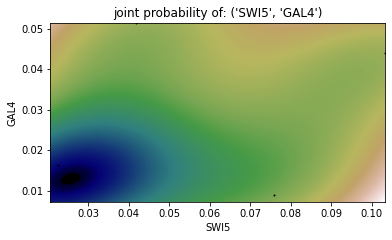

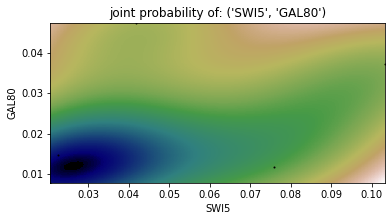

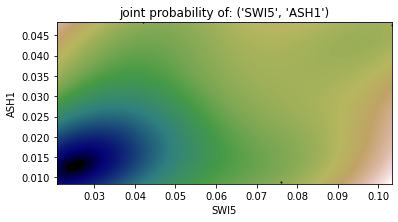

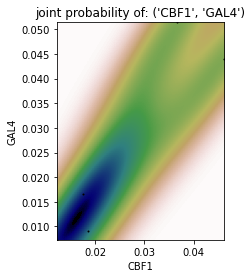

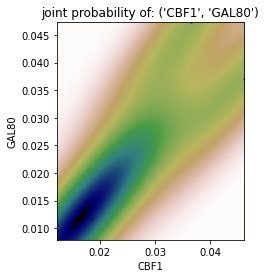

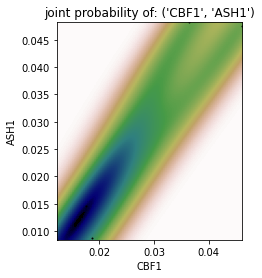

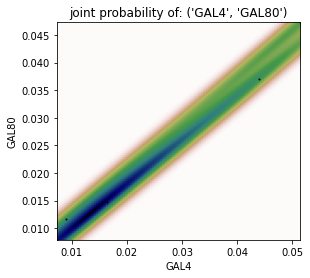

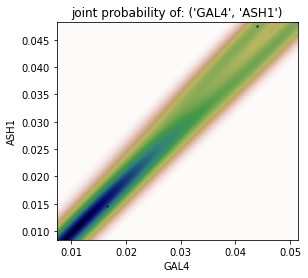

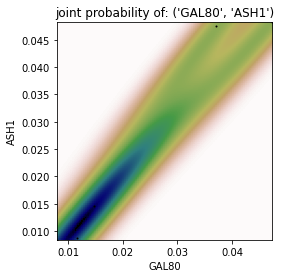

In [10]:
#to order the densities with the variables involved
joint_densities = []
count =0

for d in data_joint : #for each pairs
    
    #define the max and min of the distribution
    xmin = d[0].min()
    xmax = d[0].max()
    ymin = d[1].min()
    ymax = d[1].max()
    
    #estimate the distribution
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([d[0], d[1]])
    kernel = gaussian_kde(values)
    
    #save the density
    joint_densities.append(kernel)
    
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #plot
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    ax.plot(d[0], d[1], 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_title(f'joint probability of: {index_name[count]}')
    ax.set_xlabel((index_name[count])[0])
    ax.set_ylabel((index_name[count])[1])
    count += 1
    plt.show()


#### Mutual information computation

In [11]:
#mutual information is given by sum(p(x,y) log(p(x,y)/p(x)p(y)))

def MI(pmfx,pmfy, pmfxy) : 
    '''
    Compute the mutual inforamtion between the variable X and Y using their probability 
    mass function and the joint probability mass function.
    
    pmfx : probability mass function of X
    pmfy : probability mass funciton of Y
    
    return : float
    '''

    mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))

    #if the pmfx or pmfy contain 0 we need to set the mutual inforamtion at 0 = no info
    import math 
    for i in range(len(mutuals)) : 
        if mutuals[i] == math.inf : 
            mutuals[i] = 0
    
    return sum(mutuals)

#### Aracne Algorithm

In [12]:
def Aracne(t, densities, joint_densities, index) : 
    '''
    Aracne algorithm. Builds up an undirected graph avoiding redundancy. Conserve the edge of the graph above a threshold t and goes through every triplet edge and keeps the edge with the maximum mutual information.

    parameter
    t : float, the treshold
    densities: list of functions returning the density probability of each variable
    joint_densities : list of functions returning the density probability of each variable pair
    index : liste of a tuple with the index of the variable pairs

    return:
    G : matrix triangular superior 5x5 representing the best undirected graph for the system
    '''
    #before starting
    #simulation of the density for 10 points between 0 and 0.1
    x = np.linspace(0,0.1,100)

    z = []
    z_joint =[]

    for density in densities:
        z.append(density(x)) #for each gene 
    
    for joint_density in joint_densities:
        z_joint.append(joint_density([x,x])) #for each pairs ordered as index_name
     
    mutual_infos = np.zeros(shape = (5,5) , dtype=object)

    for i in range(len(index)):
        #mutual inforamtions
        mi = MI(z[index[i][0]-1], z[index[i][1]-1], z_joint[0])
    
        #triangular superior matrix 
        mutual_infos[index[i][0]-1][index[i][1]-1] = mi    
    
    #1 : we construct a starting graph = symetric matrix G
    G = np.ones((5,5))

    # G[i][j] = G[j][i] = 1 if MI(i, j) > t otherwise =0
    for i in range(mutual_infos.shape[0]):
        for j in range(mutual_infos.shape[1]):   
            if mutual_infos[i][j] <= t : G[i][j] = 0       
   
    #2 : we create triplets base on the existing edge on G
    triplets = []
    for i in range(0,5) :
        for j in range(i+1,5):
            for k in range(j+1 , 5):
                if G[i][j] == 1 and G[j][k] == 1 : 
                    triplets.append([(i+1, j+1),(i+1, k+1), (j+1,k+1)])
    
    G_ = G.copy() - np.eye(5) #G_ will have 1 if the egde will be remove and 0 if it will be kept
                            #G_ contain -1 on its diagonal 
    
    #for each triplet we conserve only one edge with the max MI to avoid redundant information
    for triplet in triplets :
        triplet_MI = []

        #compute the mutual information for each pairs of the triplet
        for index in triplet : 
            triplet_MI.append(mutual_infos[index[0]-1][index[1]-1])
            
        #keep only the the pair with maximum mutual information 
        max_triplet = triplet[triplet_MI.index(max(triplet_MI))]
    
        G_[max_triplet[0]-1][max_triplet[1]-1] = 0
        G_[max_triplet[1]-1][max_triplet[0]-1] = 0
      
    #3. we remove the redundant information
    return G - G_

In [13]:
treshold = 50000
g =Aracne(treshold, densities, joint_densities, index)

C:\Users\maudd\AppData\Local\Temp/ipykernel_10804/2470210154.py:14: RuntimeWarning: divide by zero encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))
C:\Users\maudd\AppData\Local\Temp/ipykernel_10804/2470210154.py:14: RuntimeWarning: overflow encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))


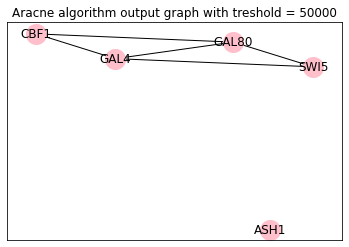

In [14]:
visualize_graph(g,treshold)

### Multistart algorithm for the first model

we can use the undirected graph given by Aracne Algorithm to create several starting directed model to optimize. We use the triangular superior graph matrix G, output of the previous section to generate graph matrix M. 

Some properties about the M matrix:
- element $M_{i,j}$ is the directed edge from j to i
- the edges given by the undirected graph have to be maintain
- the edges are directed randomly 
- the diagonal should contain 1 value to provide inversible matrix for the optimization of the parameter in the third part.

In [15]:
def multistart_generation(G, N):
    '''
    generate a list of N starting matrix according to the condition.
    
    parameters : 
    G : triangular superior matrix of 0 or 1. Contains the inforamtion about the undirected graph.
    N : int, number of starting matrix returned
    
    return : 
    list of N matrix 5x5 with 1 or 0 value
    '''
    M = []
    
    while(len(M)<N):
        m = np.zeros((5,5)) #building of the matrix
        for i in range(5) :
            for j in range(i,5):
                if G[i][j] == 1 : 
                    cond = np.random.choice(['from i to j', 'from j to i'], p=[.5, .5]) 
                    if cond == 'from i to j' : m[j][i] = 1
                    elif i == j : m[i][j] = np.random.choice([0,1], p=[.5, 0.5])
                    else : m[i][j] = 1
                    
                
        if np.linalg.det(m) != 0 : #force inversible model   
            M.append(m)         
    return M

In [16]:
#TEST : 
M = multistart_generation(g,50)

#for i in range(len(M)) : 
    #visualize_model(M[i])

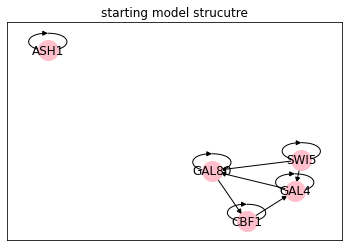

,SWI5,CBF1,GAL4,GAL80,ASH1
SWI5,1.0,0.0,0.0,0.0,0.0
CBF1,0.0,1.0,0.0,1.0,0.0
GAL4,1.0,1.0,1.0,0.0,0.0
GAL80,1.0,0.0,1.0,1.0,0.0
ASH1,0.0,0.0,0.0,0.0,1.0


In [18]:
#visualization of the average of the interactions
import sklearn
from sklearn import preprocessing

M_average = sum(M)/len(M)
M_average = preprocessing.Binarizer(threshold=0.5).transform(M_average)#np.binarize(M_average)
average_data = pd.DataFrame(M_average, index=data.columns[1:], columns=data.columns[1:])
visualize_model(M_average)
average_data.head()

## Structure optimization : greedy hill climbing 

We're using the greedy hill algorithm to find the best structure for our system. We're optimize the matrix M.

In [20]:
def greedy_hill_climbing(M, tol = 1e-2, n_iter = 1) :
    ''' 
    Create the neighborhood of M and give the optimized graphe, and iters again until convergence.
    
    parameter : 
    M: the starting graph
    
    return : 
    M_otp the optimized graph
    '''
    
    diff_score = 1e10
    
    M_opt = M.copy() #initial matrix
    best_score, theta_ML = score(M_opt) #initial store
    
    while (diff_score > tol):
        nhb = neighborhood(M_opt) #list of the neighbours
        
        new_score = best_score #new score
        
        for m in nhb: #go in the nhb and see if there is a best option
            score_m, theta_ML_m = score(m)
            if score_m > new_score : #compare with the new score
                M_opt = m
                new_score, theta_ML = score_m, theta_ML_m 
        
        diff_score = new_score - best_score
        best_score = new_score
            
    return M_opt, best_score, theta_ML

In [27]:
def neighborhood(M):
    '''
    compute the neighbors of M.  
    - add a reaction 0->1
    - delete a reaction 1->0
    
    parameter :
    M : the initial strucutre
    
    return:
    nhb : list of the neihgbors of M. size = size(M)*size(M)
    '''
    
    
    nhb = []
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            M_ = M.copy() # a copy of M
            
            #changes in the matrix
            if M[i][j] ==0 : 
                M_[i][j]= 1
            else : M_[i][j]= 0
                
            #condition to add it in the neighborhood list
            if (np.linalg.det(M_) != 0):
                
                nhb.append(M_) #add the neighborhood of M
    
    print('neighborhood size :', len(nhb)) 

    return nhb

## ODE and optimization of the parameters 

### Use matrix models

We are using linear differential equations to represent the evolution of each molecule over time.

\begin{align*}
\frac{\text{d} \textbf{x}(t)}{\text{d} t} = A^M \textbf{x}(t) + \textbf{b}
\end{align*}


There exist $2^{25}$ models.

In [29]:
def create_A_b(M, theta):
    """"Create matrix A and vector b.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with length equal to 5 + number of ones in M
    :returns: A = numpy array with shape (5,5) and b = numpy array with shape (5,1).
    Data type of returned arrays must be float.
    """
    param = 5
    A = np.zeros((param,param))
    
    for i in range(5):
        for j in range(5):
            if M[i][j] == 1 :
                A[i][j] = theta[param]
                param += 1
            
    
    b = np.reshape(theta[:5],(5,1)) 
    return A, b

In [30]:
def solve_linear_ode(A, b, t):
    """Solves the linear ODE, defined by matrix A and vector b, at time points t.
    
    :param A: a numpy array with shape (5,5)
    :param b: a numpy array with shape (5,1)
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),5), containing solutions x(t_i) as rows
    """
    L = len(t)
    X_out = np.zeros((L, 5))
    x_star = np.linalg.solve(A, -b) # solve steady state x_star = - A^{-1} b
    for j in range(L):
        xj = x_star + expm(A*t[j])@(x_init - x_star)
        X_out[j,:] = xj.flatten()
    return(X_out)

def solve_system(M, theta, t):
    """"Solve dynamics of model M with parameters theta.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with lenght equal to 5 + number of ones in M
    :param t: a one-dimensional numpy array containing output time points t_i
    :returns: a numpy array with shape (len(t),5), containing solutions x(t_i) as rows
    """
    A, b = create_A_b(M,theta)
    return solve_linear_ode(A,b,t)
    

In [31]:
def log_likelihood(M, theta):
    """"Compute log-likelihood of model M with parameters theta.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with lenght equal to 5 + number of ones in M
    :returns: one number
    """
 
    X_out = solve_system(M, theta, t_data)

    sigma = 0.15
    N = Y_data.size 
    
    log_lik = N*-np.log(sigma*np.sqrt(2*np.pi)) - 1/(2*pow(sigma,2)) * np.sum(np.square((Y_data-X_out).flatten()))
    
    return(log_lik)

In [32]:
def residuals(M, theta):
    """"Input function for least-squares optimization.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta: a list with lenght equal to 5 + number of ones in M
    :returns: vector of all residuals (y_ij - mu_ij), has shape (5*N, ) 
    """
    X_out = solve_system(M, theta, t_data)
    residuals = (Y_data - X_out).flatten()
    
    return(residuals)

In [33]:
def fit_model(M):
    """"Find maximum likelihood parameters for model M.
    
    :param M: a binary numpy array with shape (5,5)
    :returns: maximum likelihood parameters, a list with lenght equal to 5 + number of ones in M 
    """
    theta_0 = list(np.random.normal(loc=0.05,scale=0.01,size=(5+np.count_nonzero(M),)))
    residual_fun_M = lambda theta: residuals(M, theta)
    fmin = least_squares(residual_fun_M, theta_0)
    print(fmin.message)
    return fmin.x 

In [35]:
def BIC(M, theta_ML):
    """"Bayesian Information Criterion approximation for log marginal likelihood of M.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 5 + number of ones in M
    :returns: one number
    """

    n = len(t_data)
    d = len(theta_ML)
    max_lh = log_likelihood(M,theta_ML)
    
    bic = d*np.log(n) -2*max_lh


    return(bic)

In [81]:
def plot_fit(M, theta_ML):
    """"Visualize maximum likelihood fit of model M.
    
    :param M: a binary numpy array with shape (5,5)
    :param theta_ML: maximum likelihood parameters for model M, a list with 
    lenght equal to 5 + number of ones in M
    :returns: nothing
    """
    ttt = np.linspace(0, max(t_data), 100)
    mu = solve_system(M, theta_ML, ttt)
    plt.figure(figsize=(10,5))
    LL = log_likelihood(M, theta_ML)
    bic = BIC(M, theta_ML)
    cols = ["#e41a1c", "#377eb8", "#4daf4a",'green','purple']
    for j in range(0, 5):
        plt.plot(ttt, mu[:,j], color = cols[j])
        plt.plot(t_data, Y_data[:,j], marker = "o", color = cols[j], linestyle = "none")
    
    #Create the legend
    tf_names = data.columns[1:].to_numpy()
    data_types = [' fit', ' data']
    labels = np.reshape(np.concatenate((np.add(names,data_types[0]),np.add(names,data_types[1]))),(2,5)).T.flatten()
    
    plt.legend(labels)

    plt.title("LL = " + str(round(LL, 5)) + ", BIC = " + str(round(bic, 5)))
    plt.show()

In [19]:
def score(M):
    """"Returns the negative BIC of the model M. The function is implemented such as a high value means a better score.
    
    :param M: a binary numpy array with shape (5,5)
    :returns: -BIC and theta_ML
    """

    theta_ML = fit_model(M)
    return -BIC(M,theta_ML), theta_ML


In [25]:
def score(M):
    """"Returns the negative BIC of the model M. The function is implemented such as a high value means a better score.
    
    :param M: a binary numpy array with shape (5,5)
    :returns: -BIC and theta_ML
    """

    return np.sum(M),np.sum(M)


#### Ode tests

We try to fit a random matrix.

`xtol` termination condition is satisfied.


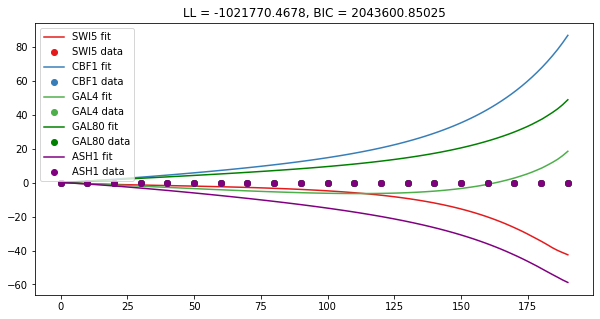

In [83]:
M_test = np.array([[1,0,1,1,1], [0,1,0,0,1], [1,0,1,1,0],[1,0,1,1,0],[1,1,0,0,1]])
theta_ML = fit_model(M_test)
plot_fit(M_test,theta_ML)

## Results

#### First try of running the model

True
neighborhood size : 23
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.
`ftol` termination condition is satisfied.
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
The maximum number of function evaluations is exceeded.
`xtol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.

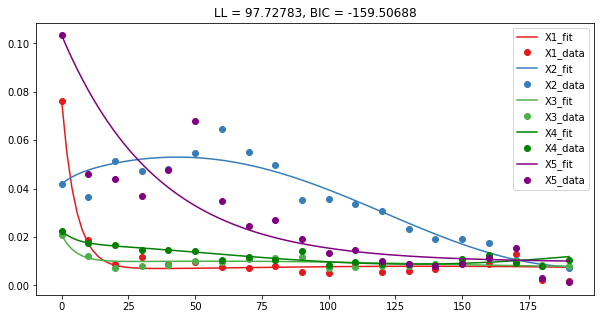

In [35]:
#test
opt_M = []
scores = []

for m in M : 
    print(np.linalg.det(m) != 0)
    if (np.linalg.det(m) != 0):
        m_opt, s, theta = greedy_hill_climbing(m)
        opt_M.append(m_opt) #we run the algorithm for each of the starting matrix 
        scores.append(s) #compute the score of the optimized matrix

best_M = opt_M[scores.index(max(scores))]
plot_fit(best_M,theta)

[[1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


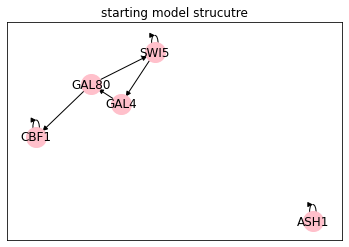

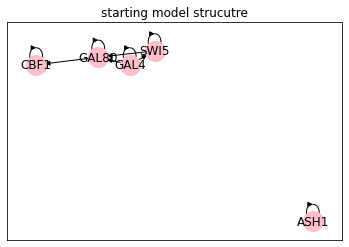

In [43]:
#visualization
print(best_M)
vizualize_model(best_M)
vizualize_model(M_b)

#### Second try of running the code

In [ ]:
opt_M = []
scores = []

for m in M : 
    print(np.linalg.det(m) != 0)
    if (np.linalg.det(m) != 0):
        m_opt, s, theta = greedy_hill_climbing(m)
        opt_M.append(m_opt) #we run the algorithm for each of the starting matrix 
        scores.append(s) #compute the score of the optimized matrix

best_M = opt_M[scores.index(max(scores))]
plot_fit(best_M,theta)

## Result analysis
### Expected model
Unfortunately, the expected model is a singular matrix, that does not fit for the ODE.

In [ ]:
M_expected = np.array([[0,0,1,0,0],
                       [1,0,0,0,1], 
                       [0,1,0,1,0],
                       [1,0,0,0,0],
                       [1,0,0,0,0]])
#plot_fit(M_expected,fit_model(M_expected))

We modify it slightly to be able to fit ODEs : we look for the best model in the neighborhood.

neighborhood size : 4
`ftol` termination condition is satisfied.
The maximum number of function evaluations is exceeded.


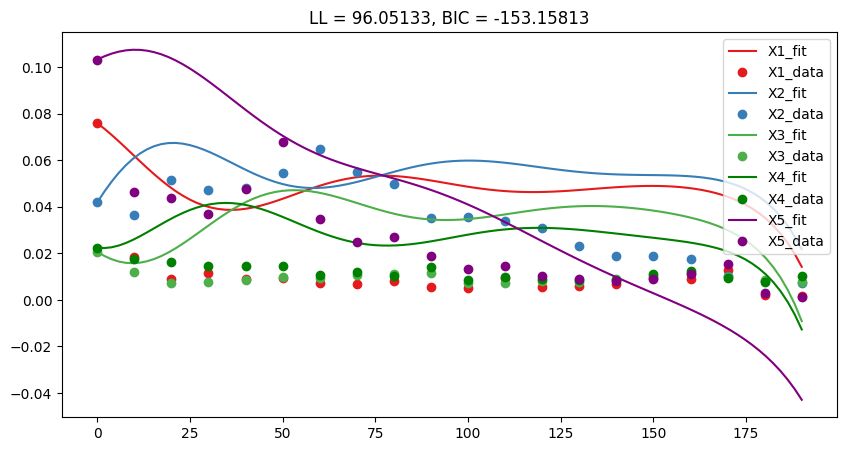

The maximum number of function evaluations is exceeded.


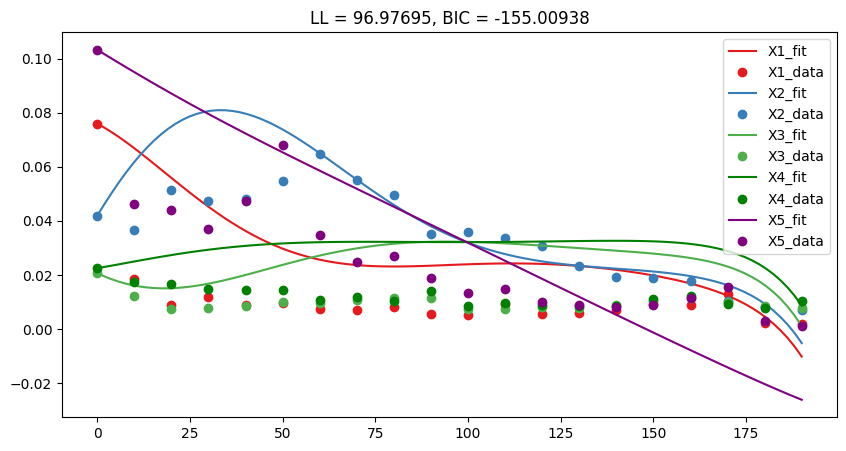

The maximum number of function evaluations is exceeded.


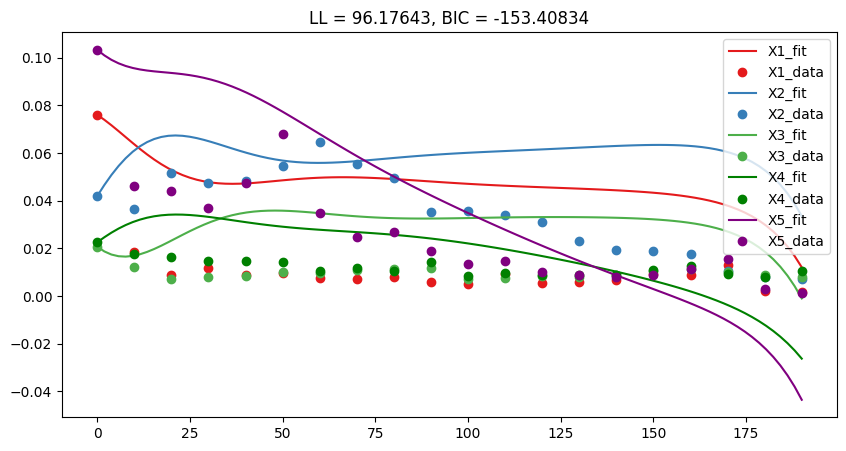

The maximum number of function evaluations is exceeded.


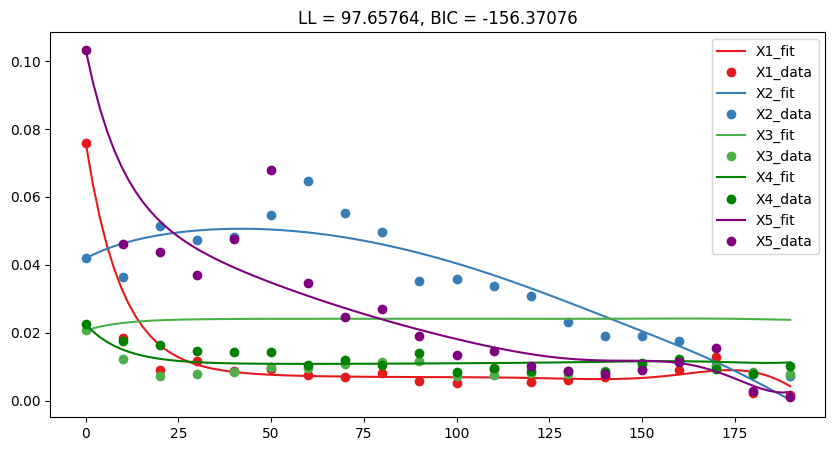

/usr/local/lib/python3.8/dist-packages/numpy/core/numeric.py:486: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return multiarray.count_nonzero(a)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [50]:
M_expected_inversible = greedy_hill_climbing2(M_expected)
plot_fit(M_expected_inversible,fit_model(M_expected_inversible))

### ROC

<ipython-input-11-f1d7d2d09d66>:14: RuntimeWarning: divide by zero encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))
<ipython-input-11-f1d7d2d09d66>:14: RuntimeWarning: overflow encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))


Text(0.5, 1.0, 'ROC')

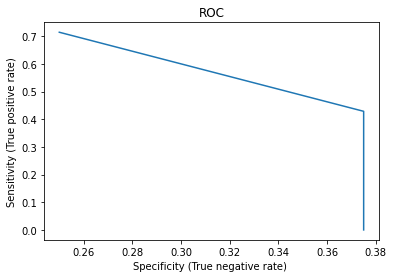

In [173]:
#the theashold taken : 
import collections 

TRH = np.linspace(1,10000000)
sensitivity =[]

specificity = []

for t in TRH:
    graph = Aracne(t, densities, joint_densities, index)
    
    diff = graph - G_true
    summ = graph + G_true 
    
    FN= np.count_nonzero(diff == -1)
    FP= np.count_nonzero(diff == 1) 
    
    TP = np.count_nonzero(summ == 2)
    TN = np.count_nonzero(summ == 0) - 10

    sensitivity.append(TP / (TP + FN))

    specificity.append(TN/ (TN + FP))
    
plt.plot(specificity, sensitivity)
plt.ylabel('Sensitivity (True positive rate)')
plt.xlabel('Specificity (True negative rate) ')
plt.title('ROC')

### ROC

In [35]:
#the undirected graph expected
G_expected = np.array([[0,1,1,1,1], 
                   [0,0,1,0,1], 
                   [0,0,0,1,0], 
                   [0,0,0,0,0], 
                   [0,0,0,0,0]])


C:\Users\maudd\AppData\Local\Temp/ipykernel_10804/2470210154.py:14: RuntimeWarning: divide by zero encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))
C:\Users\maudd\AppData\Local\Temp/ipykernel_10804/2470210154.py:14: RuntimeWarning: overflow encountered in true_divide
  mutuals= pmfxy * np.log(pmfxy/(pmfx*pmfy))


Text(0.5, 1.0, 'ROC')

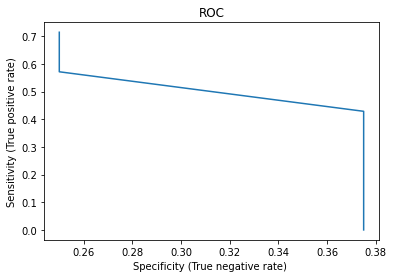

In [36]:
#the theashold taken : 
import collections 

TRH = np.linspace(1,1000000)
sensitivity =[]

specificity = []

for t in TRH:
    graph = Aracne(t, densities, joint_densities, index)
    
    diff = graph - G_expected
    summ = graph + G_expected
    
    FN= np.count_nonzero(diff == -1)
    FP= np.count_nonzero(diff == 1) 
    
    TP = np.count_nonzero(summ == 2)
    TN = np.count_nonzero(summ == 0) - 10

    sensitivity.append(TP / (TP + FN))

    specificity.append(TN/ (TN + FP))
    
plt.plot(specificity, sensitivity)
plt.ylabel('Sensitivity (True positive rate)')
plt.xlabel('Specificity (True negative rate) ')
plt.title('ROC')

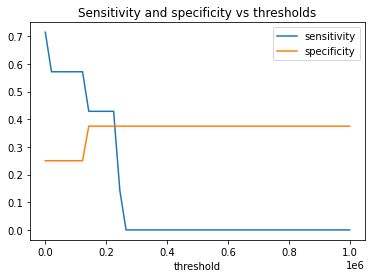

In [189]:
plt.plot(TRH, sensitivity)
plt.plot(TRH, specificity)
plt.title('Sensitivity and specificity vs thresholds')
plt.xlabel('threshold')
plt.legend(['sensitivity','specificity' ])